# hdWGCNA: Prep for network construction

In [1]:
# Conversion libraries and Seurat
library(SeuratDisk)
library(SeuratData)
library(Seurat)
library(Signac)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::reduce() masks Signac::reduce()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [2]:
# Parameters
NN <- 25
GENES <- "all"
TARGET_CELLS = 1000

In [3]:
# Files and directories
RDS_OBJ = "/cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/auxiliary_data/snrna/adrenal_Parse_10x_integrated.rds"
NAME = "normalized"
OUT = "/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/mouse_adrenal/hdwgcna/result/"

In [4]:
# Read in the R object
seurat_obj <- readRDS(RDS_OBJ)
seurat_obj

An object of class Seurat 
82892 features across 79209 samples within 3 assays 
Active assay: SCT (32171 features, 0 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

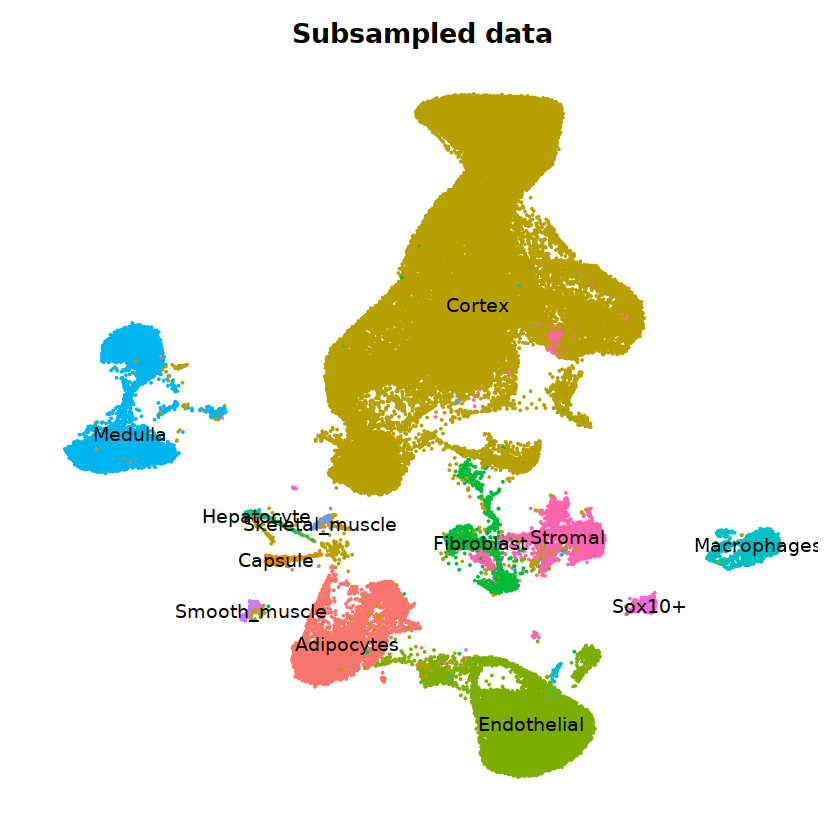

In [5]:
# Plot UMAP
p1 <- DimPlot(seurat_obj, group.by='celltypes', reduction="umap", label=TRUE) +
   umap_theme() + ggtitle('Mouse data') + NoLegend()
p1

In [6]:
# Check colnames available
DefaultAssay(seurat_obj) <- "RNA"
colnames(seurat_obj[[]])

[1] "orig.ident"                     "nCount_RNA"                    
 [3] "nFeature_RNA"                   "cellID"                        
 [5] "doublet_scores"                 "doublets"                      
 [7] "library_accession"              "technology"                    
 [9] "species"                        "tissue"                        
[11] "sex"                            "timepoint"                     
[13] "rep"                            "sample"                        
[15] "depth1"                         "depth2"                        
[17] "experiment"                     "experiment_batch"              
[19] "integration_batch"              "run_number"                    
[21] "experiment_accession"           "file_accession"                
[23] "lower_nCount_RNA"               "upper_nCount_RNA"              
[25] "lower_nFeature_RNA"             "upper_doublet_scores"          
[27] "upper_percent.mt"               "percent.mt"                    
[29] "percent.ribo"                   "nCount_SCT"                    
[31] "nFeature_SCT"                   "integrated_snn_res.1.6"        
[33] "seurat_clusters"                "S.Score"                       
[35] "G2M.Score"                      "Phase"                         
[37] "subtypes"                       "celltypes"                     
[39] "gen_celltype"                   "Cortex_membership_score"       
[41] "Endothelial_membership_score"   "Adipocytes_membership_score"   
[43] "Myeloid_membership_score"       "Sox10._membership_score"       
[45] "Fibroblast_membership_score"    "Medulla_membership_score"      
[47] "Stromal_membership_score"       "Smooth_muscle_membership_score"
[49] "Capsule_membership_score"       "Hepatocyte_membership_score"   
[51] "Myonuclei_membership_score"     "gen_celltype_membership_score"

In [8]:
table(seurat_obj$sample)


 A_10_F_1  A_10_F_2  A_10_M_1  A_10_M_2  A_14_F_1  A_14_F_2  A_14_M_1  A_14_M_2 
      439       255      1040       797      8673      5301      6280      5832 
A_18m_F_1 A_18m_F_2 A_18m_M_1 A_18m_M_2  A_25_F_1  A_25_F_2  A_25_M_1  A_25_M_2 
     2411       903       556       221      2678       395      3659       863 
 A_2m_F_1  A_2m_F_2  A_2m_M_1  A_2m_M_2  A_36_F_1  A_36_F_2  A_36_M_1  A_36_M_2 
     7986      5119      6928      5283      3063       882      4224       714 
  A_4_F_1   A_4_F_2   A_4_M_1   A_4_M_2 
      885      1177      1276      1369 

In [9]:
# Set-up a Seurat object for WGCNA
seurat_obj <- SetupForWGCNA(
    seurat_obj,
    gene_select = "fraction", # the gene selection approach
    fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
    wgcna_name = NAME # the name of the hdWGCNA experiment
)

In [10]:
# Construct metacells n each group
seurat_obj <- MetacellsByGroups(
  seurat_obj=seurat_obj,
  group.by=c("celltypes", "sample"), # specify the columns in adata@meta.data to group by
  k=25, # nearest-neighbors parameter
  max_shared=10, # maximum number of shared cells between two metacells
  ident.group='celltypes', # set the Idents of the metacell seurat object
  assay="RNA",
  slot="counts",
  target_metacells=1000,
)

Warning message in MetacellsByGroups(seurat_obj = seurat_obj, group.by = c("celltypes", :
“Removing the following groups that did not meet min_cells: Adipocytes#A_10_F_1, Adipocytes#A_10_F_2, Adipocytes#A_18m_F_2, Adipocytes#A_18m_M_2, Adipocytes#A_25_F_2, Adipocytes#A_36_F_2, Adipocytes#A_36_M_2, Adipocytes#A_4_F_1, Adipocytes#A_4_F_2, Adipocytes#A_4_M_1, Adipocytes#A_4_M_2, Capsule#A_10_F_1, Capsule#A_10_F_2, Capsule#A_10_M_1, Capsule#A_10_M_2, Capsule#A_14_F_1, Capsule#A_14_F_2, Capsule#A_14_M_1, Capsule#A_14_M_2, Capsule#A_18m_F_1, Capsule#A_18m_F_2, Capsule#A_18m_M_1, Capsule#A_18m_M_2, Capsule#A_25_F_1, Capsule#A_25_M_1, Capsule#A_25_M_2, Capsule#A_2m_F_1, Capsule#A_2m_F_2, Capsule#A_2m_M_1, Capsule#A_2m_M_2, Capsule#A_36_F_1, Capsule#A_36_F_2, Capsule#A_36_M_1, Capsule#A_36_M_2, Capsule#A_4_F_1, Capsule#A_4_F_2, Capsule#A_4_M_1, Capsule#A_4_M_2, Cortex#A_18m_M_2, Endothelial#A_10_F_1, Endothelial#A_10_F_2, Endothelial#A_10_M_1, Endothelial#A_18m_M_1, Endothelial#A_18m_M_2, Endot

[1] "done making metacells"
[1] 108
[1] "metacell shape"


In [13]:
# transpose the matrix, taking care of the
seurat_obj <- SetDatExpr(
    seurat_obj, 
    assay="RNA", 
    use_metacells=TRUE, 
    wgcna_name=NAME, 
    slot="data"
)

In [14]:
# Test different soft powers:
seurat_obj <- TestSoftPowers(
  seurat_obj,
  use_metacells=TRUE,  # this is the default, I'm just being explicit
  setDatExpr=FALSE  # set this to FALSE since we did this above
)

pickSoftThreshold: will use block size 4707.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4707 of 9503


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 4708 through 9414 of 9503


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 9415 through 9503 of 9503


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.8260  8.570          0.921 6210.00   6320.00   7200
2      2   0.7270  2.970          0.910 4160.00   4260.00   5580
3      3   0.4390  1.250          0.811 2840.00   2910.00   4410
4      4   0.0812  0.384          0.707 1980.00   2010.00   3540
5      5   0.0116 -0.130          0.724 1410.00   1400.00   2870
6      6   0.1660 -0.521          0.785 1010.00    979.00   2360
7      7   0.3350 -0.834          0.816  741.00    691.00   1960
8      8   0.4550 -1.030          0.863  549.00    492.00   1640
9      9   0.5430 -1.200          0.893  412.00    353.00   1380
10    10   0.6060 -1.330          0.910  313.00    254.00   1170
11    12   0.6940 -1.550          0.933  187.00    134.00    863
12    14   0.7390 -1.690          0.945  116.00     72.20    648
13    16   0.7700 -1.750          0.959   74.30     40.20    496
14    18   0.7800 -1.790          0.968   49.20     22.90    386
15    20   0.8020 -1.800 

In [13]:
# get the power table, can also access with head(get(NAME, seurat_obj@misc)$wgcna_powerTable)
power_table <- GetPowerTable(seurat_obj)
power <- power_table$Power[which(power_table$SFT.R.sq > 0.85)[1]]

  Power   SFT.R.sq      slope truncated.R.sq  mean.k. median.k.   max.k.
1     1 0.82578002  8.5706091      0.9208840 6214.164 6321.9902 7198.220
2     2 0.72747738  2.9681347      0.9097660 4160.173 4264.8784 5580.632
3     3 0.43922264  1.2473120      0.8105260 2844.467 2911.6679 4407.910
4     4 0.08117083  0.3842948      0.7068999 1982.420 2007.4095 3535.458
5     5 0.01159670 -0.1301230      0.7239434 1405.929 1396.0474 2872.584
6     6 0.16639715 -0.5212128      0.7845258 1013.151  978.5143 2360.091
[1] "return"


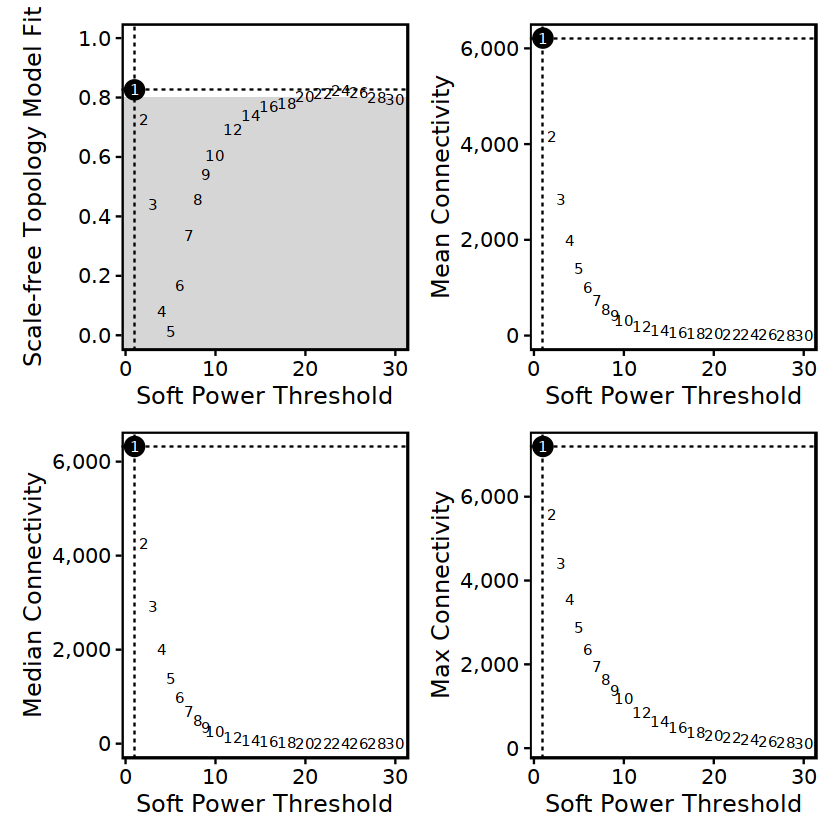

In [15]:
# plot the results:
plot_list <- PlotSoftPowers(seurat_obj)
wrap_plots(plot_list, ncol=2)

In [ ]:
# Save the fully processed Seurat object to be used in all the other notebooks
saveRDS(seurat_obj, file=file.path(OUT, paste0(NAME, "_hdWGCNA.rds")))

---

# Scratch